# Facial Emotion Recognition

#### Table of Contents:

1. [Library Imports](#Library-Imports)
2. [Data Reading & Splitting](#Data-Reading-and-Splitting)
3. [Data Visualization](#Data-Visualization)
4. [Exploratory Data Analysis](#EDA)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Metrics](#Model-Metrics)
7. [Model Training](#Model-Training)
 - [Logistic Regression Baseline](#Logistic-Regression-Baseline)
 - [Simple Neural Network Baseline](#Simple-Neural-Network-Baseline)
 - [Simple Convolutional Neural Network Baseline](#Simple-Convolutional-Neural-Network-Baseline)
 - [Convolutional Neural Network](#Convolutional-Neural-Network-Model)
 - [Transfer Learning](#Transfer-Learning)

### Library Imports

In [11]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras import regularizers as reg
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, SpatialDropout2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Reading and Splitting

In [3]:
batch_size = 32
img_height = 180
img_width = 180

# dataset directories
train_dir = 'Data/affect_net_dataset/train'
valid_dir = 'Data/affect_net_dataset/validation'
test_dir = 'Data/affect_net_dataset/test'

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 33803 files belonging to 7 classes.
Found 1750 files belonging to 7 classes.
Found 1750 files belonging to 7 classes.


### Data Visualization

In [59]:
class_names = train_data.class_names
num_classes = len(class_names)
print(class_names)

['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


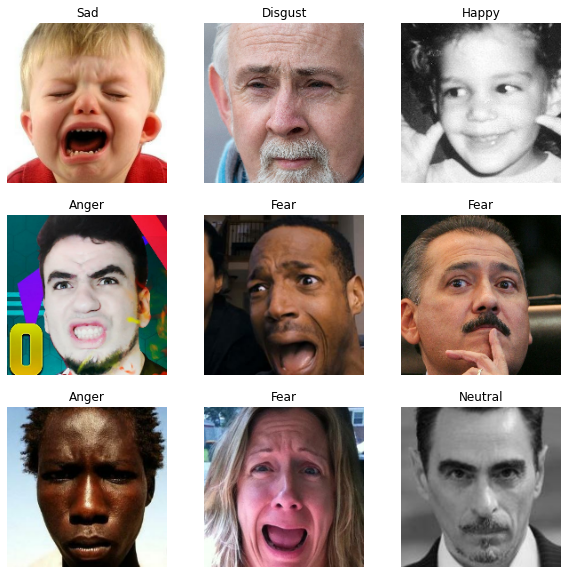

In [77]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### EDA

In [151]:
labels = []
for folder in os.listdir('Data/affect_net_dataset/train'):
    emotion = os.fsdecode(folder)
    for file in os.listdir(f'Data/affect_net_dataset/train/{emotion}'):
        labels.append(emotion)

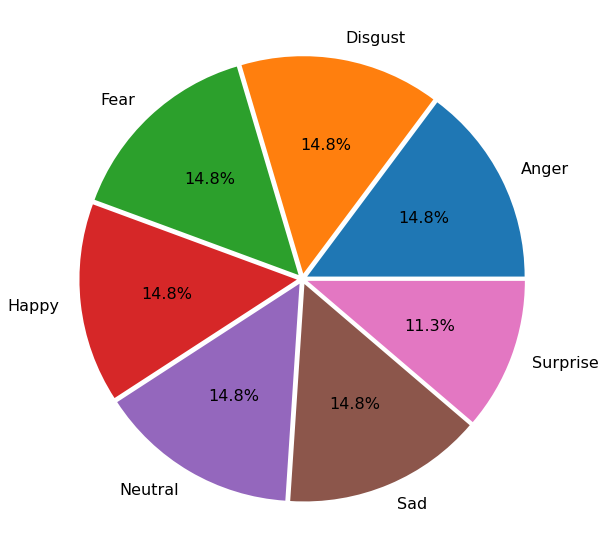

In [154]:
plt.figure(figsize=[10, 10])
plt.pie(pd.DataFrame(labels).value_counts(), [.025, .025, .025, .025, .025, .025, .025], labels=class_names, autopct='%1.1f%%', textprops={'fontsize': 16});
plt.savefig('Deliverables/Images/class_imbalance.png', bbox_inches='tight', transparent=True)

### Data Augmentation

- Resize the images (180x180)
- Scaling/Normalization (1 to 255)
- Randomly flip images (Horizontally)
- Randomly rotate images (up to 20°)

In [5]:
data_augmentation = Sequential([
    Resizing(img_width, img_height),
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

### Model Metrics

In [103]:
def plot_model_performance(hist, model_name=None, save=False):
    model_hist = pd.DataFrame(hist.history)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=model_hist[['accuracy', 'val_accuracy']])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    
    if save and model_name:
        plt.title(f'{model_name} Accuracy Graph')
        plt.savefig(f'Deliverables/Images/{model_name} accuracy graph.png', transparent=True, bbox_inches='tight')

### Model Training

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

##### Simple Neural Network Baseline

In [8]:
sbase_NN = Sequential()

sbase_NN.add(data_augmentation)

sbase_NN.add(Dense(16, activation='relu'))

sbase_NN.add(Flatten())
sbase_NN.add(Dense(7, activation='softmax'))

sbase_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
sbase_NN_hist = sbase_NN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
1174/1174 [==============================] - 19s 16ms/step - loss: 661.8455 - accuracy: 0.1867 - val_loss: 30.9066 - val_accuracy: 0.1795
Epoch 2/5
1174/1174 [==============================] - 14s 12ms/step - loss: 15.2690 - accuracy: 0.1902 - val_loss: 9.2841 - val_accuracy: 0.1575
Epoch 3/5
1174/1174 [==============================] - 13s 11ms/step - loss: 5.1859 - accuracy: 0.2246 - val_loss: 5.5396 - val_accuracy: 0.1735
Epoch 4/5
1174/1174 [==============================] - 13s 11ms/step - loss: 2.8387 - accuracy: 0.2568 - val_loss: 4.0047 - val_accuracy: 0.1615
Epoch 5/5
1174/1174 [==============================] - 13s 11ms/step - loss: 2.3025 - accuracy: 0.2753 - val_loss: 2.9754 - val_accuracy: 0.1665


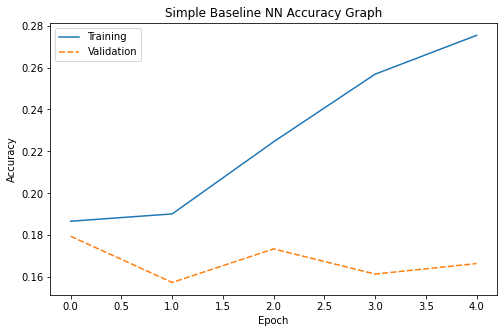

In [10]:
plot_model_performance(sbase_NN_hist, 'Simple Baseline NN', save=True)

In [11]:
train_loss, train_acc = sbase_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = sbase_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

63/63 [==============================] - 0s 6ms/step - loss: 2.9754 - accuracy: 0.1665


Training Accuracy:	30.89233934879303
Training Loss:		2.0056018829345703

Validation Accuracy:	16.65000021457672
Validation Loss:	2.9753544330596924

Train/Validation Diff:	 14.242339134216309


##### Neural Network Baseline

In [29]:
base_NN = Sequential()

base_NN.add(data_augmentation)

base_NN.add(Dense(8, activation='relu'))

base_NN.add(Dense(16, activation='relu'))

base_NN.add(Dense(32, activation='relu'))

base_NN.add(Dense(64, activation='relu'))

base_NN.add(Dense(32, activation='relu'))

base_NN.add(Dense(16, activation='relu'))

base_NN.add(Flatten())
base_NN.add(Dense(7, activation='softmax'))

base_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
base_NN_hist = base_NN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
1174/1174 [==============================] - 96s 81ms/step - loss: 2.1956 - accuracy: 0.1305 - val_loss: 2.0845 - val_accuracy: 0.1250
Epoch 2/5
1174/1174 [==============================] - 93s 79ms/step - loss: 2.0730 - accuracy: 0.1254 - val_loss: 2.0863 - val_accuracy: 0.1250
Epoch 3/5
1174/1174 [==============================] - 95s 81ms/step - loss: 2.0730 - accuracy: 0.1257 - val_loss: 2.0865 - val_accuracy: 0.1250
Epoch 4/5
1174/1174 [==============================] - 94s 80ms/step - loss: 2.0730 - accuracy: 0.1254 - val_loss: 2.0865 - val_accuracy: 0.1250
Epoch 5/5
1174/1174 [==============================] - 91s 77ms/step - loss: 2.0730 - accuracy: 0.1255 - val_loss: 2.0865 - val_accuracy: 0.1250


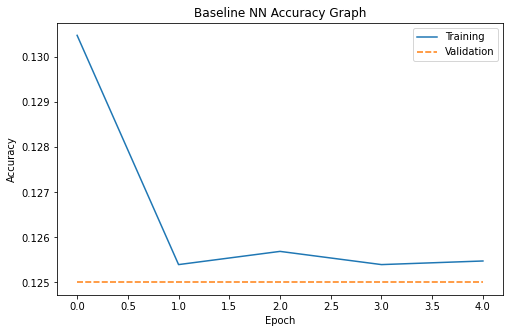

In [31]:
plot_model_performance(base_NN_hist, 'Baseline NN', save=True)

In [32]:
train_loss, train_acc = base_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

63/63 [==============================] - 3s 40ms/step - loss: 2.0865 - accuracy: 0.1250


Training Accuracy:	13.314515352249146
Training Loss:		2.0727968215942383

Validation Accuracy:	12.5
Validation Loss:	2.0864901542663574

Train/Validation Diff:	 0.8145153522491455


##### Simple Convolutional Neural Network Baseline

In [33]:
base_CNN = Sequential()

base_CNN.add(data_augmentation)

base_CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())

base_CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())

base_CNN.add(Flatten())
base_CNN.add(Dense(7, activation='softmax'))

base_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
base_CNN_hist = base_CNN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
1174/1174 [==============================] - 20s 15ms/step - loss: 2.0538 - accuracy: 0.1694 - val_loss: 2.0103 - val_accuracy: 0.2155
Epoch 2/5
1174/1174 [==============================] - 17s 15ms/step - loss: 1.9725 - accuracy: 0.2360 - val_loss: 1.9363 - val_accuracy: 0.2530
Epoch 3/5
1174/1174 [==============================] - 17s 15ms/step - loss: 1.9245 - accuracy: 0.2608 - val_loss: 1.8999 - val_accuracy: 0.2695
Epoch 4/5
1174/1174 [==============================] - 17s 14ms/step - loss: 1.8947 - accuracy: 0.2773 - val_loss: 1.8795 - val_accuracy: 0.2850
Epoch 5/5
1174/1174 [==============================] - 16s 14ms/step - loss: 1.8792 - accuracy: 0.2822 - val_loss: 1.8764 - val_accuracy: 0.2710


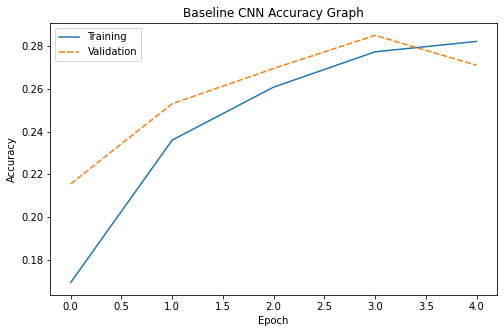

In [35]:
plot_model_performance(base_CNN_hist, 'Baseline CNN', save=True)

In [36]:
train_loss, train_acc = base_CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

63/63 [==============================] - 0s 5ms/step - loss: 1.8764 - accuracy: 0.2710


Training Accuracy:	29.366496205329895
Training Loss:		1.8377926349639893

Validation Accuracy:	27.09999978542328
Validation Loss:	1.8764443397521973

Train/Validation Diff:	 2.266496419906616


##### Convolutional Neural Network Model

In [42]:
sgd_opt = SGD(learning_rate=0.001)

In [52]:
adam_opt = Adam(learning_rate=0.0001)

In [53]:
CNN = Sequential()

CNN.add(data_augmentation)

CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=256, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(GlobalAveragePooling2D())

CNN.add(Dense(7, activation='softmax'))

CNN.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [54]:
CNN_hist = CNN.fit(train_data, epochs=300, validation_data=valid_data, verbose=1, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=.25, patience=4, verbose=1)])

Epoch 1/300
1057/1057 [==============================] - 32s 29ms/step - loss: 6.7559 - accuracy: 0.1463 - val_loss: 5.9015 - val_accuracy: 0.1434 - lr: 1.0000e-04
Epoch 2/300
1057/1057 [==============================] - 30s 29ms/step - loss: 5.5297 - accuracy: 0.1513 - val_loss: 4.8930 - val_accuracy: 0.1423 - lr: 1.0000e-04
Epoch 3/300
1057/1057 [==============================] - 30s 28ms/step - loss: 4.5696 - accuracy: 0.1545 - val_loss: 4.0666 - val_accuracy: 0.1434 - lr: 1.0000e-04
Epoch 4/300
1057/1057 [==============================] - 30s 29ms/step - loss: 3.7525 - accuracy: 0.1554 - val_loss: 3.3356 - val_accuracy: 0.1423 - lr: 1.0000e-04
Epoch 5/300
1057/1057 [==============================] - 30s 28ms/step - loss: 3.0725 - accuracy: 0.1572 - val_loss: 2.7632 - val_accuracy: 0.1463 - lr: 1.0000e-04
Epoch 6/300
1057/1057 [==============================] - 30s 28ms/step - loss: 2.5930 - accuracy: 0.1612 - val_loss: 2.3993 - val_accuracy: 0.1457 - lr: 1.0000e-04
Epoch 7/300
1057

Epoch 51/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.8718 - accuracy: 0.3253 - val_loss: 1.7459 - val_accuracy: 0.3720 - lr: 2.5000e-05
Epoch 52/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.8458 - accuracy: 0.3291 - val_loss: 1.7300 - val_accuracy: 0.3760 - lr: 2.5000e-05
Epoch 53/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.8334 - accuracy: 0.3343 - val_loss: 1.7183 - val_accuracy: 0.3760 - lr: 2.5000e-05
Epoch 54/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.8186 - accuracy: 0.3378 - val_loss: 1.7079 - val_accuracy: 0.3783 - lr: 2.5000e-05
Epoch 55/300
1057/1057 [==============================] - 32s 31ms/step - loss: 1.8071 - accuracy: 0.3374 - val_loss: 1.6941 - val_accuracy: 0.3909 - lr: 2.5000e-05
Epoch 56/300
1057/1057 [==============================] - 33s 31ms/step - loss: 1.7976 - accuracy: 0.3413 - val_loss: 1.6873 - val_accuracy: 0.3811 - lr: 2.5000e-05
Epoch 57/3

Epoch 100/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6815 - accuracy: 0.3715 - val_loss: 1.5604 - val_accuracy: 0.4251 - lr: 6.2500e-06
Epoch 101/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6759 - accuracy: 0.3778 - val_loss: 1.5627 - val_accuracy: 0.4234 - lr: 6.2500e-06
Epoch 102/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6794 - accuracy: 0.3726 - val_loss: 1.5592 - val_accuracy: 0.4246 - lr: 6.2500e-06
Epoch 103/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6729 - accuracy: 0.3753 - val_loss: 1.5546 - val_accuracy: 0.4257 - lr: 6.2500e-06
Epoch 104/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6741 - accuracy: 0.3751 - val_loss: 1.5599 - val_accuracy: 0.4274 - lr: 6.2500e-06
Epoch 105/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6695 - accuracy: 0.3783 - val_loss: 1.5549 - val_accuracy: 0.4251 - lr: 6.2500e-06
Epoc

1057/1057 [==============================] - 33s 31ms/step - loss: 1.6383 - accuracy: 0.3858 - val_loss: 1.5247 - val_accuracy: 0.4354 - lr: 2.3283e-14
Epoch 185/300
1057/1057 [==============================] - 33s 31ms/step - loss: 1.6385 - accuracy: 0.3908 - val_loss: 1.5246 - val_accuracy: 0.4349 - lr: 2.3283e-14
Epoch 186/300
1057/1057 [==============================] - 33s 31ms/step - loss: 1.6424 - accuracy: 0.3877 - val_loss: 1.5244 - val_accuracy: 0.4360 - lr: 2.3283e-14
Epoch 187/300
1057/1057 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.3887
Epoch 00187: ReduceLROnPlateau reducing learning rate to 5.820765944301821e-15.
1057/1057 [==============================] - 33s 31ms/step - loss: 1.6381 - accuracy: 0.3887 - val_loss: 1.5252 - val_accuracy: 0.4377 - lr: 2.3283e-14
Epoch 188/300
1057/1057 [==============================] - 33s 31ms/step - loss: 1.6335 - accuracy: 0.3902 - val_loss: 1.5251 - val_accuracy: 0.4349 - lr: 5.8208e-15
Epoch 189/300
105

Epoch 224/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.6332 - accuracy: 0.3911 - val_loss: 1.5254 - val_accuracy: 0.4343 - lr: 2.2204e-20
Epoch 225/300
1057/1057 [==============================] - 32s 30ms/step - loss: 1.6386 - accuracy: 0.3859 - val_loss: 1.5250 - val_accuracy: 0.4371 - lr: 2.2204e-20
Epoch 226/300
1057/1057 [==============================] - 32s 31ms/step - loss: 1.6370 - accuracy: 0.3920 - val_loss: 1.5252 - val_accuracy: 0.4343 - lr: 2.2204e-20
Epoch 227/300
1057/1057 [==============================] - ETA: 0s - loss: 1.6378 - accuracy: 0.3932
Epoch 00227: ReduceLROnPlateau reducing learning rate to 5.5511149828928195e-21.
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6378 - accuracy: 0.3932 - val_loss: 1.5250 - val_accuracy: 0.4366 - lr: 2.2204e-20
Epoch 228/300
1057/1057 [==============================] - 31s 29ms/step - loss: 1.6402 - accuracy: 0.3874 - val_loss: 1.5243 - val_accuracy: 0.4371 - lr: 5.5511e-21
Ep

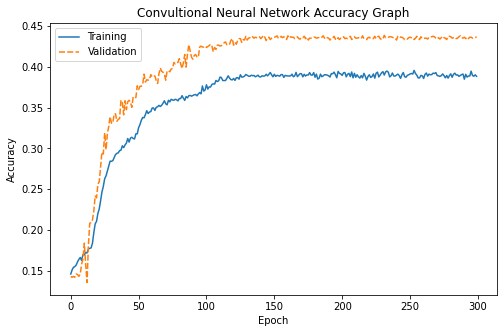

In [55]:
plot_model_performance(CNN_hist, 'Convultional Neural Network', save=True)

In [56]:
train_loss, train_acc = CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 1s 16ms/step - loss: 1.5247 - accuracy: 0.4366


Training Accuracy:	45.44271230697632
Training Loss:		1.490562915802002

Validation Accuracy:	43.65714192390442
Validation Loss:	1.5247435569763184

Train/Validation Diff:	 1.7855703830718994


In [58]:
CNN.save('Deliverables/cnn_model.h5')

##### Transfer Learning

Using DenseNet

In [78]:
dense_net = DenseNet169(weights='imagenet', include_top=False, input_shape=None)

for layer in dense_net.layers:
    layer.trainable = False

51888128/51877672 [==============================] - 3s 0us/step


In [79]:
CNN_dense_transfer = Sequential()

CNN_dense_transfer.add(dense_net)

CNN_dense_transfer.add(GlobalAveragePooling2D())

CNN_dense_transfer.add(Dense(256 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())
CNN_dense_transfer.add(Dense(128 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())

CNN_dense_transfer.add(Dense(7, activation='softmax'))

CNN_dense_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_opt, metrics = ['accuracy'])
CNN_dense_transfer.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d_5   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_45 (Dense)            (None, 256)               426240    
                                                                 
 batch_normalization_35 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_36 (Bat  (None, 128)            

In [80]:
CNN_dense_transfer_hist = CNN_dense_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1)

Epoch 1/10
1057/1057 [==============================] - 102s 91ms/step - loss: 2.2973 - accuracy: 0.1639 - val_loss: 2.1373 - val_accuracy: 0.2057
Epoch 2/10
1057/1057 [==============================] - 90s 85ms/step - loss: 2.0810 - accuracy: 0.2074 - val_loss: 2.0932 - val_accuracy: 0.2223
Epoch 3/10
1057/1057 [==============================] - 90s 85ms/step - loss: 2.0037 - accuracy: 0.2234 - val_loss: 2.0085 - val_accuracy: 0.2263
Epoch 4/10
1057/1057 [==============================] - 91s 86ms/step - loss: 1.9549 - accuracy: 0.2400 - val_loss: 1.9806 - val_accuracy: 0.2280
Epoch 5/10
1057/1057 [==============================] - 90s 85ms/step - loss: 1.9258 - accuracy: 0.2496 - val_loss: 1.9557 - val_accuracy: 0.2251
Epoch 6/10
1057/1057 [==============================] - 93s 88ms/step - loss: 1.8975 - accuracy: 0.2609 - val_loss: 1.9365 - val_accuracy: 0.2406
Epoch 7/10
1057/1057 [==============================] - 91s 86ms/step - loss: 1.8814 - accuracy: 0.2656 - val_loss: 1.9288 

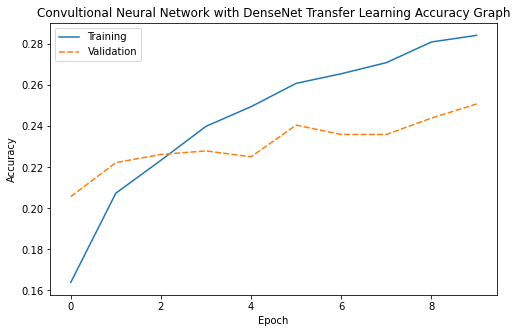

In [81]:
plot_model_performance(CNN_dense_transfer_hist, 'Convultional Neural Network with DenseNet Transfer Learning', save=True)

In [82]:
train_loss, train_acc = CNN_dense_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_dense_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 5s 80ms/step - loss: 1.9086 - accuracy: 0.2509


Training Accuracy:	29.92633879184723
Training Loss:		1.8091150522232056

Validation Accuracy:	25.08571445941925
Validation Loss:	1.9086257219314575

Train/Validation Diff:	 4.8406243324279785


Using VGG16

In [84]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 2s 0us/step


In [86]:
CNN_vgg_transfer = Sequential()

CNN_vgg_transfer.add(data_augmentation)

CNN_vgg_transfer.add(vgg)

CNN_vgg_transfer.add(GlobalAveragePooling2D())

CNN_vgg_transfer.add(Dense(256 , activation ='relu'))
CNN_vgg_transfer.add(BatchNormalization())
CNN_vgg_transfer.add(Dense(256 , activation ='relu'))
CNN_vgg_transfer.add(BatchNormalization())

CNN_vgg_transfer.add(Dense(7, activation='softmax'))

CNN_vgg_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [87]:
CNN_vgg_transfer_hist = CNN_vgg_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15
1057/1057 [==============================] - 98s 88ms/step - loss: 1.8092 - accuracy: 0.3072 - val_loss: 1.7391 - val_accuracy: 0.3457
Epoch 2/15
1057/1057 [==============================] - 89s 84ms/step - loss: 1.6901 - accuracy: 0.3377 - val_loss: 1.7354 - val_accuracy: 0.3354
Epoch 3/15
1057/1057 [==============================] - 88s 83ms/step - loss: 1.6667 - accuracy: 0.3515 - val_loss: 1.6288 - val_accuracy: 0.3629
Epoch 4/15
1057/1057 [==============================] - 88s 83ms/step - loss: 1.6459 - accuracy: 0.3580 - val_loss: 1.6450 - val_accuracy: 0.3720
Epoch 5/15
1057/1057 [==============================] - 89s 84ms/step - loss: 1.6260 - accuracy: 0.3706 - val_loss: 1.6194 - val_accuracy: 0.3783
Epoch 6/15
1057/1057 [==============================] - 95s 89ms/step - loss: 1.6094 - accuracy: 0.3783 - val_loss: 1.6372 - val_accuracy: 0.3709
Epoch 7/15
1057/1057 [==============================] - 93s 88ms/step - loss: 1.6068 - accuracy: 0.3761 - val_loss: 1.6031 -

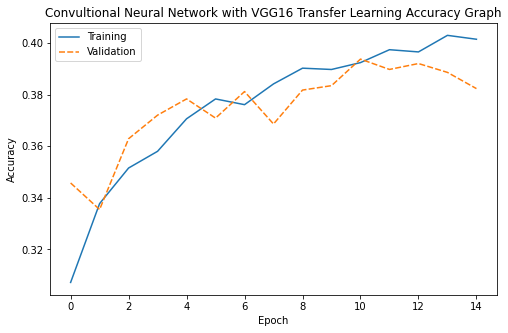

In [88]:
plot_model_performance(CNN_vgg_transfer_hist, 'Convultional Neural Network with VGG16 Transfer Learning', save=True)

In [89]:
train_loss, train_acc = CNN_vgg_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_vgg_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 4s 75ms/step - loss: 1.6019 - accuracy: 0.3823


Training Accuracy:	42.00514853000641
Training Loss:		1.5130189657211304

Validation Accuracy:	38.22857141494751
Validation Loss:	1.6018882989883423

Train/Validation Diff:	 3.776577115058899


Using VGG19

In [112]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg_19.layers[:-2]:
    layer.trainable = False

In [113]:
CNN_vgg_19_transfer = Sequential()

CNN_vgg_19_transfer.add(data_augmentation)

CNN_vgg_19_transfer.add(vgg_19)

CNN_vgg_19_transfer.add(GlobalAveragePooling2D())

CNN_vgg_19_transfer.add(Dense(256 , activation ='relu'))
CNN_vgg_19_transfer.add(BatchNormalization())
CNN_vgg_19_transfer.add(Dense(256 , activation ='relu'))
CNN_vgg_19_transfer.add(BatchNormalization())

CNN_vgg_19_transfer.add(Dense(7, activation='softmax'))

CNN_vgg_19_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [114]:
CNN_vgg_19_transfer_hist = CNN_vgg_19_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15
1057/1057 [==============================] - 97s 91ms/step - loss: 1.7537 - accuracy: 0.3226 - val_loss: 1.7618 - val_accuracy: 0.3383
Epoch 2/15
1057/1057 [==============================] - 98s 93ms/step - loss: 1.5863 - accuracy: 0.3843 - val_loss: 1.8616 - val_accuracy: 0.2886
Epoch 3/15
1057/1057 [==============================] - 101s 95ms/step - loss: 1.5343 - accuracy: 0.4058 - val_loss: 1.7538 - val_accuracy: 0.3514
Epoch 4/15
1057/1057 [==============================] - 100s 95ms/step - loss: 1.5005 - accuracy: 0.4213 - val_loss: 1.5159 - val_accuracy: 0.4183
Epoch 5/15
1057/1057 [==============================] - 95s 90ms/step - loss: 1.4709 - accuracy: 0.4329 - val_loss: 1.5105 - val_accuracy: 0.4251
Epoch 6/15
1057/1057 [==============================] - 98s 92ms/step - loss: 1.4521 - accuracy: 0.4438 - val_loss: 1.5869 - val_accuracy: 0.4011
Epoch 7/15
1057/1057 [==============================] - 96s 91ms/step - loss: 1.4258 - accuracy: 0.4537 - val_loss: 1.6537

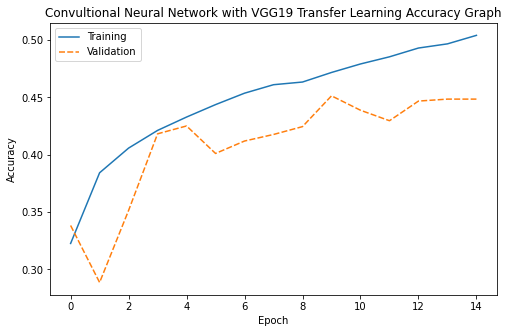

In [117]:
plot_model_performance(CNN_vgg_19_transfer_hist, 'Convultional Neural Network with VGG19 Transfer Learning', save=True)

In [118]:
train_loss, train_acc = CNN_vgg_19_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_vgg_19_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 5s 84ms/step - loss: 1.4868 - accuracy: 0.4486


Training Accuracy:	51.0161817073822
Training Loss:		1.2971198558807373

Validation Accuracy:	44.85714137554169
Validation Loss:	1.4868407249450684

Train/Validation Diff:	 6.159040331840515


Using InceptionV3

In [119]:
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=None)

for layer in inception_v3.layers[:-1]:
    layer.trainable = False

87924736/87910968 [==============================] - 4s 0us/step


In [124]:
CNN_inception_transfer = Sequential()

CNN_inception_transfer.add(data_augmentation)

CNN_inception_transfer.add(inception_v3)

CNN_inception_transfer.add(GlobalAveragePooling2D())

CNN_inception_transfer.add(Dense(256 , activation ='relu'))
CNN_inception_transfer.add(BatchNormalization())
CNN_inception_transfer.add(Dense(256 , activation ='relu'))
CNN_inception_transfer.add(BatchNormalization())

CNN_inception_transfer.add(Dense(7 , activation='softmax'))

CNN_inception_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics = ['accuracy'])

In [125]:
CNN_inception_transfer_hist = CNN_inception_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15
1057/1057 [==============================] - 58s 52ms/step - loss: 1.8510 - accuracy: 0.2815 - val_loss: 1.7357 - val_accuracy: 0.3211
Epoch 2/15
1057/1057 [==============================] - 53s 50ms/step - loss: 1.7303 - accuracy: 0.3219 - val_loss: 1.7006 - val_accuracy: 0.3349
Epoch 3/15
1057/1057 [==============================] - 55s 52ms/step - loss: 1.7070 - accuracy: 0.3331 - val_loss: 1.7265 - val_accuracy: 0.3160
Epoch 4/15
1057/1057 [==============================] - 55s 52ms/step - loss: 1.6954 - accuracy: 0.3371 - val_loss: 1.7094 - val_accuracy: 0.3394
Epoch 5/15
1057/1057 [==============================] - 54s 51ms/step - loss: 1.6856 - accuracy: 0.3442 - val_loss: 1.7412 - val_accuracy: 0.3143
Epoch 6/15
1057/1057 [==============================] - 55s 52ms/step - loss: 1.6741 - accuracy: 0.3476 - val_loss: 1.7616 - val_accuracy: 0.3286
Epoch 7/15
1057/1057 [==============================] - 54s 51ms/step - loss: 1.6736 - accuracy: 0.3458 - val_loss: 1.6981 -

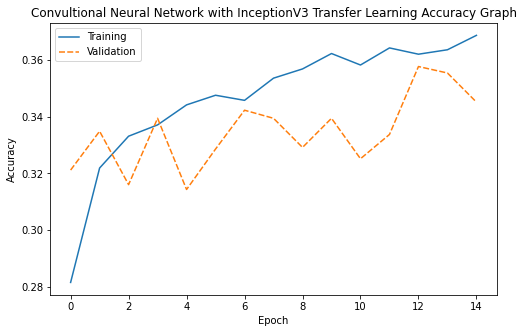

In [126]:
plot_model_performance(CNN_inception_transfer_hist, 'Convultional Neural Network with InceptionV3 Transfer Learning', save=True)

In [127]:
train_loss, train_acc = CNN_inception_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_inception_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 2s 43ms/step - loss: 1.6743 - accuracy: 0.3451


Training Accuracy:	38.08537721633911
Training Loss:		1.6357229948043823

Validation Accuracy:	34.51428711414337
Validation Loss:	1.6742830276489258

Train/Validation Diff:	 3.5710901021957397


Using ResNet50

In [128]:
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=None)

for layer in resnet_50.layers[:-1]:
    layer.trainable = False

94781440/94765736 [==============================] - 3s 0us/step


In [129]:
CNN_resnet_transfer = Sequential()

CNN_resnet_transfer.add(data_augmentation)

CNN_resnet_transfer.add(resnet_50)

CNN_resnet_transfer.add(GlobalAveragePooling2D())

CNN_resnet_transfer.add(Dense(512 , activation ='relu'))
CNN_resnet_transfer.add(BatchNormalization())
CNN_resnet_transfer.add(Dense(256 , activation ='relu'))
CNN_resnet_transfer.add(BatchNormalization())

CNN_resnet_transfer.add(Dense(7 , activation='softmax'))

CNN_resnet_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [130]:
CNN_resnet_transfer_hist = CNN_resnet_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15
1057/1057 [==============================] - 80s 73ms/step - loss: 1.9844 - accuracy: 0.1868 - val_loss: 3.4887 - val_accuracy: 0.1577
Epoch 2/15
1057/1057 [==============================] - 77s 73ms/step - loss: 1.9243 - accuracy: 0.2076 - val_loss: 2.5760 - val_accuracy: 0.1914
Epoch 3/15
1057/1057 [==============================] - 80s 76ms/step - loss: 1.9127 - accuracy: 0.2178 - val_loss: 2.2681 - val_accuracy: 0.2086
Epoch 4/15
1057/1057 [==============================] - 80s 76ms/step - loss: 1.9042 - accuracy: 0.2219 - val_loss: 4.5390 - val_accuracy: 0.1537
Epoch 5/15
1057/1057 [==============================] - 80s 75ms/step - loss: 1.8985 - accuracy: 0.2292 - val_loss: 2.2319 - val_accuracy: 0.1720
Epoch 6/15
1057/1057 [==============================] - 79s 74ms/step - loss: 1.8942 - accuracy: 0.2307 - val_loss: 3.0327 - val_accuracy: 0.1823
Epoch 7/15
1057/1057 [==============================] - 80s 76ms/step - loss: 1.8856 - accuracy: 0.2365 - val_loss: 2.7733 -

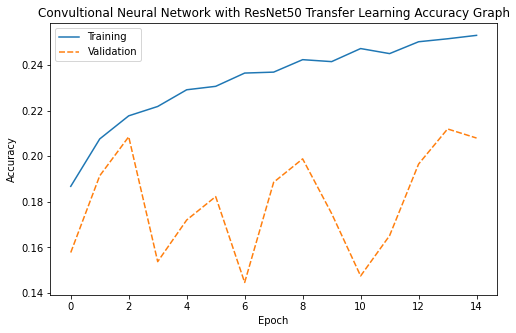

In [131]:
plot_model_performance(CNN_resnet_transfer_hist, 'Convultional Neural Network with ResNet50 Transfer Learning', save=True)

In [132]:
train_loss, train_acc = CNN_resnet_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_resnet_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

55/55 [==============================] - 4s 65ms/step - loss: 1.9274 - accuracy: 0.2080


Training Accuracy:	18.51314902305603
Training Loss:		1.9464551210403442

Validation Accuracy:	20.800000429153442
Validation Loss:	1.927385926246643

Train/Validation Diff:	 2.286851406097412


##### Chosen Model

From all the models that were testted above, the best model in terms of highest accuracy and least loss and overfit, is the `VGG19` transfer learning model

In [7]:
train_valid_data = train_data.concatenate(valid_data)

In [8]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg_19.layers[:-2]:
    layer.trainable = False

In [9]:
CNN_vgg_19_transfer = Sequential()

CNN_vgg_19_transfer.add(data_augmentation)

CNN_vgg_19_transfer.add(vgg_19)

CNN_vgg_19_transfer.add(GlobalAveragePooling2D())
CNN_vgg_19_transfer.add(Dropout(0.3))

CNN_vgg_19_transfer.add(Dense(256 , activation ='relu'))
CNN_vgg_19_transfer.add(Dropout(0.5))
# CNN_vgg_19_transfer.add(BatchNormalization())

CNN_vgg_19_transfer.add(Dense(1024 , activation ='relu'))
CNN_vgg_19_transfer.add(Dropout(0.5))
# CNN_vgg_19_transfer.add(BatchNormalization())

CNN_vgg_19_transfer.add(Dense(512 , activation ='relu'))
CNN_vgg_19_transfer.add(Dropout(0.5))
# CNN_vgg_19_transfer.add(BatchNormalization())

CNN_vgg_19_transfer.add(Dense(7, activation='softmax'))

CNN_vgg_19_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [12]:
CNN_vgg_19_transfer_hist = CNN_vgg_19_transfer.fit(train_valid_data, epochs=100, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto'), ReduceLROnPlateau(monitor='loss', factor=.5, patience=3, verbose=1)])

Epoch 1/100
1112/1112 [==============================] - 107s 90ms/step - loss: 1.8159 - accuracy: 0.2540 - lr: 0.0010
Epoch 2/100
1112/1112 [==============================] - 93s 84ms/step - loss: 1.7031 - accuracy: 0.3132 - lr: 0.0010
Epoch 3/100
1112/1112 [==============================] - 89s 80ms/step - loss: 1.6721 - accuracy: 0.3309 - lr: 0.0010
Epoch 4/100
1112/1112 [==============================] - 91s 82ms/step - loss: 1.6510 - accuracy: 0.3456 - lr: 0.0010
Epoch 5/100
1112/1112 [==============================] - 93s 83ms/step - loss: 1.6313 - accuracy: 0.3540 - lr: 0.0010
Epoch 6/100
1112/1112 [==============================] - 91s 82ms/step - loss: 1.6242 - accuracy: 0.3602 - lr: 0.0010
Epoch 7/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.6144 - accuracy: 0.3647 - lr: 0.0010
Epoch 8/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.6108 - accuracy: 0.3647 - lr: 0.0010
Epoch 9/100
1112/1112 [==============================] 

1112/1112 [==============================] - 92s 83ms/step - loss: 1.4747 - accuracy: 0.4348 - lr: 1.2500e-04
Epoch 65/100
1112/1112 [==============================] - 93s 84ms/step - loss: 1.4740 - accuracy: 0.4306 - lr: 1.2500e-04
Epoch 66/100
1112/1112 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.4298
Epoch 00066: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1112/1112 [==============================] - 92s 83ms/step - loss: 1.4745 - accuracy: 0.4298 - lr: 1.2500e-04
Epoch 67/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.4691 - accuracy: 0.4342 - lr: 6.2500e-05
Epoch 68/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.4703 - accuracy: 0.4337 - lr: 6.2500e-05
Epoch 69/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.4689 - accuracy: 0.4316 - lr: 6.2500e-05
Epoch 70/100
1112/1112 [==============================] - 92s 83ms/step - loss: 1.4702 - accuracy: 0.4326 - l

In [14]:
train_loss, train_acc = CNN_vgg_19_transfer.evaluate(train_valid_data, verbose=1)
test_loss, test_acc = CNN_vgg_19_transfer.evaluate(test_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{test_acc * 100}\nValidation Loss:\t{test_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - test_acc) * 100)

55/55 [==============================] - 4s 76ms/step - loss: 1.4723 - accuracy: 0.4463


Training Accuracy:	48.02407622337341
Training Loss:		1.3978674411773682

Validation Accuracy:	44.62857246398926
Validation Loss:	1.4723188877105713

Train/Validation Diff:	 3.3955037593841553


In [15]:
CNN_vgg_19_transfer.save('Deliverables/CNN_vgg_19_final.h5')